In [5]:
import ollama
import pandas as pd
from datasets import load_dataset

from datasets import Dataset 
from ragas.metrics import summarization_score
from ragas import evaluate

In [6]:
ds = load_dataset("sujayC66/text_summarization_512_length_1_4000")
df = pd.DataFrame(ds['train'])
df = df.rename(columns={"content": "text"})
df.head()

,text,summary,__index_level_0__
0,"LONDON - Hunting PLC (LSE: HTG), a precision e...",Hunting PLC's 2023 financial performance align...,1124
1,Promoter entity of Sapphire Foods India Arinja...,"Sapphire Foods India's promoter, Arinjaya (Mau...",1097
2,"Gold price climbed Rs 410 to Rs 61,210 per 10 ...","Gold prices rose by Rs 410 to Rs 61,210 per 10...",1258
3,"New Delhi, Jan 11 (IANS) Life Insurance Corp...","LIC received orders for Rs 3,528 crore from In...",856
4,"“I don’t want to sound alarmist, but it pays t...",MFIs have become the largest providers of micr...,1718


In [7]:
df = df.drop(columns = ["summary", "__index_level_0__"])

In [8]:
df = df.sample(10)

In [9]:
def word_count(text):
    return len(text.split())

In [10]:
df["nwords_text"] = df["text"].apply(word_count)
df.head()

,text,nwords_text
15,"Shimla, Jan 10 (IANS) A four-member multi-inst...",159
461,SYDNEY - The Australian dollar experienced a n...,211
1836,"New Delhi, Jan 11 (IANS) Life Insurance Corp...",218
2792,"New Delhi, Jan 15 (IANS) In a recent developme...",254
3165,The current market scenario for the Nifty Meta...,396


In [11]:
def generate_summary(text, model):
    
    nwords_summary = int(0.2*word_count(text))
    
    prompt =  f"Your goal is to summarize the given text in maximum {nwords_summary} words. \
               Extract the most important information. \
               Only output the summary without any additional text."

    
    response = ollama.chat(model=model, messages=[
        {
            'role': 'system',
            'content': prompt
        },
        {
            'role': 'user',
            'content': text,
        },
    ])
    summary = response['message']['content']
    
    return summary

In [12]:
ollms = ["llama3.1", "mistral", "phi3", "gemma2",  "qwen2:7b"]  

In [13]:
for llm in ollms: 
    print(llm)
    df[llm + "_summary"] = df["text"].apply(lambda x: generate_summary(x, model=llm))

llama3.1
mistral
phi3
gemma2
qwen2:7b


In [14]:
#df["summary"] = df["text"].apply(lambda x: generate_summary(x, model='phi3'))

In [15]:
for llm in ollms: 
    col = llm + "_summary"
    col_cnt = llm + "_summary_nwords_percnt"
    df[col_cnt] = df[col].apply(word_count)
    df[col_cnt] = 100*df[col_cnt]/df['nwords_text']
    

In [16]:
df.head()

,text,nwords_text,llama3.1_summary,mistral_summary,phi3_summary,gemma2_summary,qwen2:7b_summary,llama3.1_summary_nwords_percnt,mistral_summary_nwords_percnt,phi3_summary_nwords_percnt,gemma2_summary_nwords_percnt,qwen2:7b_summary_nwords_percnt
15,"Shimla, Jan 10 (IANS) A four-member multi-inst...",159,A team of scientists from Himachal Pradesh's N...,"A team of scientists, including Monica Sharma...","A team led by Monica Sharma, Associate Profes...","A team of scientists, including Monica Sharma ...","A four-member multi-institutional team, includ...",17.610063,23.899371,42.138365,15.094340,16.352201
461,SYDNEY - The Australian dollar experienced a n...,211,The Australian dollar fell below US66 cents am...,1. Australian dollar falls below US66 cents ma...,Australian dollar dips below 66 cents US; Col...,The Australian dollar fell below US66 cents as...,The Australian dollar fell below US66 cents as...,18.957346,49.289100,18.957346,25.592417,47.393365
1836,"New Delhi, Jan 11 (IANS) Life Insurance Corp...",218,Life Insurance Corporation of India received o...,"LIC India receives Rs 3,528 crore demand from...","LIC of India faces orders worth Rs. 3,528 cro...","LIC received Income Tax orders for Rs 3,528 cr...",Life Insurance Corporation of India received o...,26.605505,21.100917,26.605505,22.477064,24.770642
2792,"New Delhi, Jan 15 (IANS) In a recent developme...",254,Lenders of cash-strapped Go First have extende...,Airline Go First: Lenders extend deadline for...,Resolution Professional of Go First extends f...,Go First's lenders have extended the deadline ...,Lenders of cash-strapped Go First have extende...,13.779528,21.653543,27.559055,20.078740,21.259843
3165,The current market scenario for the Nifty Meta...,396,"The Nifty Metal Index is in a bearish trend, w...",The Nifty Metal Index shows a bearish trend w...,The Nifty Metal Index is currently bearish wi...,The Nifty Metal Index exhibits a bearish trend...,The Nifty Metal Index shows a near-term bearis...,19.191919,18.939394,18.939394,17.171717,22.727273


In [17]:
contexts =  [[text] for text in df["text"]]

In [19]:
from langchain_community.llms import Ollama
evaluator_llm = Ollama(model="mistral", timeout=600)

In [20]:
from langchain.chat_models import ChatOpenAI
evaluator_llm  = ChatOpenAI(model_name="gpt-4o-mini")

/Users/sridharkannam/anaconda3/envs/py99/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [23]:
df_scores = pd.DataFrame()

for llm in ollms: 
    print(llm)
    col = llm + "_summary"
    data_samples = {
        'contexts' : contexts,
        'summary': df[col].to_list()
    }

    dataset = Dataset.from_dict(data_samples)
    
    score = evaluate(dataset,
                     metrics=[summarization_score],
                     llm=evaluator_llm,
                    )
    
    df_scores[llm] = score.to_pandas()['summary_score']

llama3.1


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

mistral


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

phi3


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

gemma2


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

qwen2:7b


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
df_scores.head()

,llama3.1,mistral,phi3,gemma2,qwen2:7b
0,0.525074,0.453217,0.548158,0.496961,0.448621
1,0.598834,0.697873,0.598739,0.599133,0.622644
2,0.532754,0.503204,0.555257,0.652181,0.559006
3,0.630851,0.621481,0.727112,0.652778,0.594208
4,0.727854,0.872764,0.729596,0.825914,0.893865


In [25]:
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame `df`
# Calculating the mean and standard deviation for each model
mean_scores = df_scores.mean()
std_scores = df_scores.std()

# Creating a DataFrame for plotting
summary_df = pd.DataFrame({
    'Model': mean_scores.index,
    'Mean Score': mean_scores.values,
    'Standard Deviation': std_scores.values
})

# Sorting the DataFrame to ensure the order in the plot
summary_df = summary_df.sort_values('Mean Score', ascending=True)

In [26]:
summary_df

,Model,Mean Score,Standard Deviation
0,llama3.1,0.610823,0.085385
2,phi3,0.617078,0.120851
4,qwen2:7b,0.641175,0.134254
3,gemma2,0.652462,0.086709
1,mistral,0.657950,0.141080


In [27]:
summary_df['Mean Score'] = summary_df['Mean Score'].round(2)

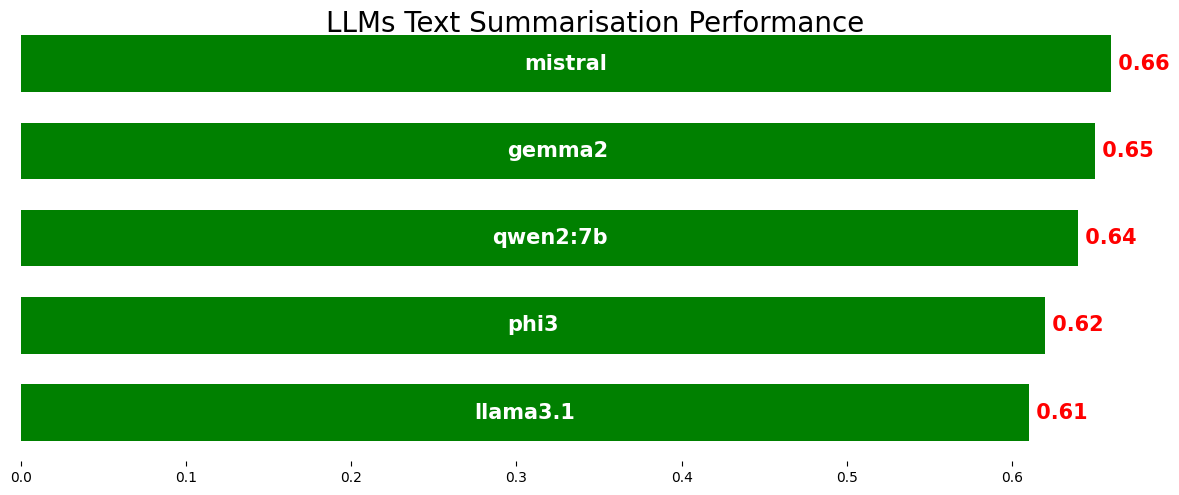

In [31]:
# Create the plot with a transparent figure
fig, ax = plt.subplots(figsize=(12, 5), facecolor='none', edgecolor='none')
fig.patch.set_alpha(0)

# Create horizontal bar plot
bars = ax.barh(summary_df['Model'], summary_df['Mean Score'], height=0.65, color="green"
              )

# Remove y-axis labels
ax.set_yticks([])

# Remove the frame
for spine in ax.spines.values():
    spine.set_visible(False)

# Add count labels to the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f' {width}', 
            ha='left', va='center', fontweight='bold', fontsize=15, color='red')

# Add name labels inside each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width/2, bar.get_y() + bar.get_height()/2, summary_df['Model'].iloc[i], 
            ha='center', va='center', fontweight='bold', fontsize=15, color='white')

# Set the title
#ax.set_title('Count by Name', fontsize=16, fontweight='bold', pad=20)

# Remove x-axis label
ax.set_xlabel('')

# Set the background of the axis to transparent
ax.patch.set_alpha(0)

# Adjust layout and display the plot
plt.tight_layout()

plt.suptitle("LLMs Text Summarisation Performance", fontsize=20)
# Save the figure with transparent background
plt.savefig('summary1.png', dpi=300, bbox_inches='tight', transparent=True)

# Display the plot (optional, remove if you only want to save the file)
plt.show()